# Investigating Hybrid Strategies for Systematic Literature Review

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2016
reload()
# !pip install matplotlib-venn


In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.planilha = {
                work for work in current.visited 
                if int(getattr(work, "planilha_{}".format(current.name), 0))
            }
            current.planilha_selected = {
                work for work in current.related 
                if int(getattr(work, "planilha_{}".format(current.name), 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            #if current.planilha:
            #    options.append((" planilha", len(current.planilha)))
            #    options.append((" planilha selected", len(current.planilha_selected)))
            #    options.append((" duplicados", len(current.visited - current.planilha)))
            
            #if current.name == "scopus2016":
            #    current.name = "Scopus"
                          
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        
                       # if current.name == "scopus2016":
                       #     current.name = "Scopus"
                                               
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        
                       # if current.name == "scopus2016":
                       #     current.name = "Scopus"
                                        
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", 
        "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "excel", "excel_selected", "duplicated",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
        excel = {
            work for work in current.visited 
            if int(getattr(work, "planilha_{}".format(current.name), 0))
        }
        excel_selected = {
            work for work in current.related 
            if int(getattr(work, "planilha_{}".format(current.name), 0))
        } 
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            len(excel),
            len(excel_selected),
            len(current.visited - excel) if excel else 0,
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [3]:
print ("\nTotal de estudos primários reproduzidos = 16 do Seed Set + 4 encontrados durante o Snowballing =", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))


Total de estudos primários reproduzidos = 16 do Seed Set + 4 encontrados durante o Snowballing = 20


In [4]:
reload()
#TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);



 Provenance Graph - Strategy 1 - Database Search


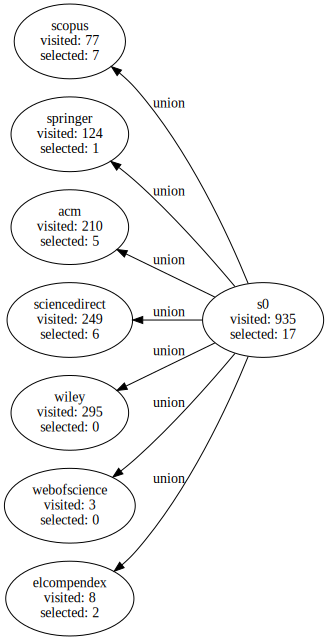

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl [:-4]
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

bibliotecas = ["scopus2016", "springer2016", "acm2016", "sciencedirect2016", "wiley2016", "webofscience2016", "elcompendex2016",]
strategy = busca_completa(bibliotecas, filter_function)
state = strategy.initial
final = FinalSelection(strategy.initial)
print("\n \033[1mProvenance Graph - Strategy 1 - Database Search\033[0m")
final

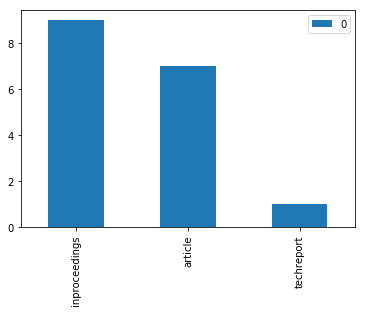

In [6]:
lista = [work.entrytype for work in state.related]
df = pd.DataFrame (lista)

df.apply(pd.value_counts).plot(kind="bar")

In [7]:
[work.year for work in state.related] 

[2016,
 2014,
 2016,
 2015,
 2013,
 2015,
 2016,
 2013,
 2014,
 2010,
 2013,
 2014,
 2007,
 2011,
 2015,
 2010,
 2015]

In [8]:
{work
 for _, work in load_work_map_all_years()
 for bib in bibliotecas
 for bib2 in bibliotecas
 if bib != bib2
 if int(getattr(work, "planilha_{}".format(bib), 0))
 if int(getattr(work, "planilha_{}".format(bib2), 0))
}

{An obsolescence management framework for system baseline evolution-perspectives through the system life cycle}

In [9]:
# salva o gráfico de proveniência no formato para incluir em pdf, word.
def salvar(state, arquivo):
    with open("{}.dot".format(arquivo), "w") as f:
        f.write(state.dot)
    !dot -Tsvg {arquivo}.dot -o {arquivo}.svg
    #!inkscape -f {arquivo}.svg -e {arquivo}.png -d 300

In [10]:
salvar(final, "final")

In [11]:
#strategy.initial.seed_set @ metakey_title
#strategy.initial.visited

In [12]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[[-1]])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
#df = df.drop(df.index[[-1,7]]) #exclude row first=-1 and last=7=s0
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
        
df1 = df[["state","precision", "recall", "fmeasure" ]]
df1.columns = ['Digital Library', 'Precision %', 'Recall %', 'F-Measure %']

#print (df1.to_string(index=False))
#df1_style.hide_index()


df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']
df2 = df2.loc[df['state'] == 's0']

df1 = df1.drop(df.index[[-1,7]])

df2_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 1 - Database Search\033[0m")
df2_style


 Report Strategy 1 - Database Search


,Digital Library,Precision %,Recall %,F-Measure %
0,elcompendex,25,10,14.3
1,webofscience,0,0,0
2,wiley,0,0,0
3,sciencedirect,2.4,30,4.5
4,acm,2.4,25,4.3
5,springer,0.8,5,1.4
6,scopus,9.1,35,14.4



  Bar Chart Strategy 1 


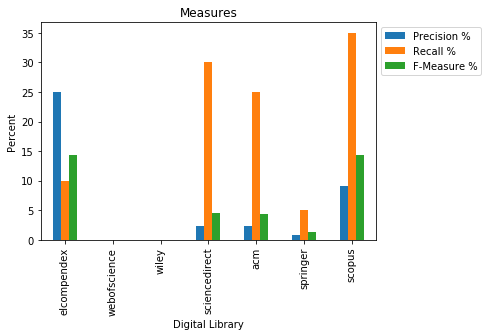

In [13]:
df1.plot.bar(y=['Precision %','Recall %','F-Measure %'])
ax = plt.gca()
ax.set_title("Measures")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("Digital Library")
plt.ylabel("Percent")
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')

In [14]:
df2_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 1 Measures (Accumulated) \033[0m")
df2_style


 Report Strategy 1 Measures (Accumulated) 


,Precision %,Recall %,F-Measure %,Visited,Selected
7,1.8,85,3.6,935,17


In [15]:

df3 = df[["state","visited", "related", "excel", "excel_selected", "duplicated", "final_selected"]]
df3.columns = ['Digital Library', 'Visited', 'Selected', 'Excel', 'Excel Selected', 'Duplicated', 'Final Selected']
df3 = df3.drop(df.index[[-1,7]]) #remove ultima linha que contem o state s0.

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1m Report Strategy 1 - Excel and Duplicated Included\033[0m")
df3_style


  Report Strategy 1 - Excel and Duplicated Included


,Digital Library,Visited,Selected,Excel,Excel Selected,Duplicated,Final Selected
0,elcompendex,8,2,0,0,0,0
1,webofscience,3,0,0,0,0,0
2,wiley,295,0,0,0,0,0
3,sciencedirect,249,6,0,0,0,1
4,acm,210,5,0,0,0,3
5,springer,124,1,0,0,0,0
6,scopus,77,7,0,0,0,2


## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


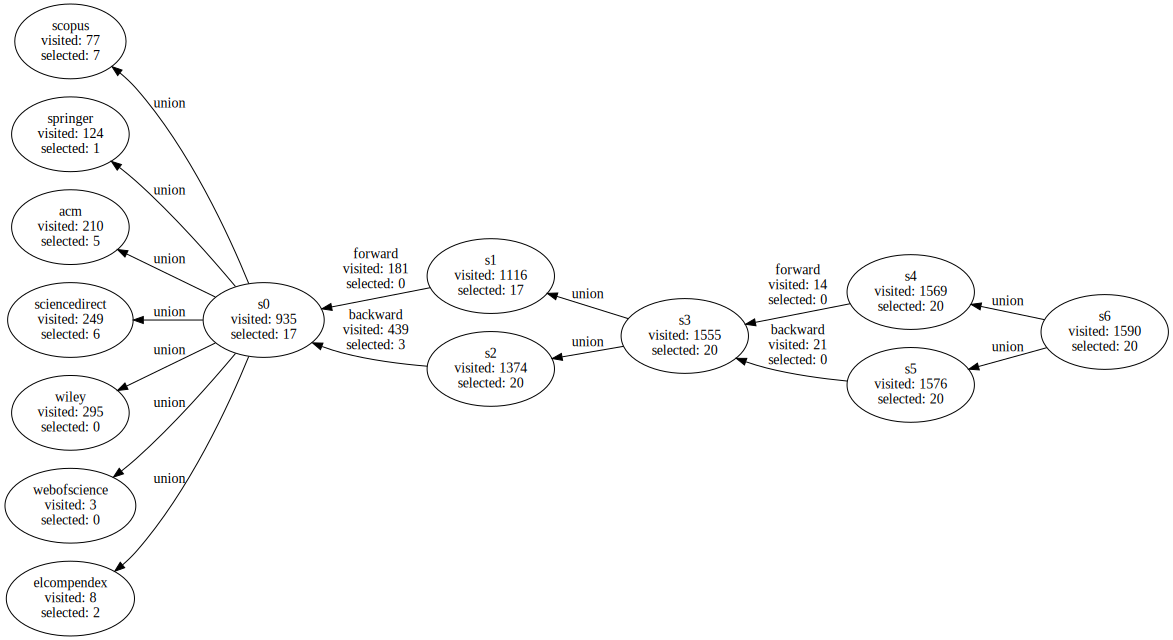

In [16]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["scopus2016", "springer2016", "acm2016", "sciencedirect2016", "wiley2016", "webofscience2016", "elcompendex2016",], filter_function)
state = strategy.sfbu()

print("\n \033[1mProvenance Graph - Strategy 2 - Database Search + Snowballing (Guideline Wohlin)\033[0m")

FinalSelection(state)

In [17]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

#d_decimals = 3    
#for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
#      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
#df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
    
    
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Digital Library/State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]

    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 2 - Database Search + Snowballing (Guideline Wohlin)\033[0m")
df1_style


 Report Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


,Digital Library/State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,elcompendex,25,10,14.3,-,25,10,14.3,8,8,2,2
1,webofscience,0,0,0,-,0,0,0,3,3,0,0
2,wiley,0,0,0,-,0,0,0,295,295,0,0
3,sciencedirect,2.4,30,4.5,-,2.4,30,4.5,249,249,6,6
4,acm,2.4,25,4.3,-,2.4,25,4.3,210,210,5,5
5,springer,0.8,5,1.4,-,0.8,5,1.4,124,124,1,1
6,scopus,9.1,35,14.4,-,9.1,35,14.4,77,77,7,7
7,s0,nan,0,0,union,1.8,85,3.6,0,935,0,17
8,s2,0.7,15,1.3,backward,1.5,100,2.9,439,1374,3,20
9,s1,0,0,0,forward,1.5,85,3,181,1116,0,17


In [18]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 2 - Measures (Accumulated) \033[0m")
df3_style



 Report Strategy 2 - Measures (Accumulated) 


,Precision %,Recall %,F-Measure %,Visited,Selected
13,1.3,100,2.5,1590,20


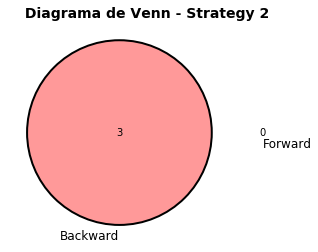

In [19]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 2',fontsize="14", fontweight="bold")
plt.show()

In [20]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['saddington2012a', 'barton2009a', 'eloranta2013a']
Forward []


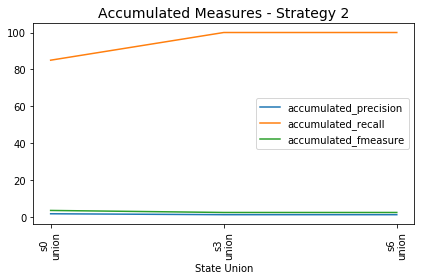

In [21]:
# ---- Grafico de linha para Somente Union 
df = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State Union")
ax.set_title("Accumulated Measures - Strategy 2", fontsize="14");
plt.tight_layout()


In [22]:
#df = df.loc[df['operation'] == 'backward'].reset_index(drop=True)
#fig = plt.figure()
#df['precision'].plot(legend=True)
#df['recall'].plot(legend=True)
#df['fmeasure'].plot(legend=True)
#ax = plt.gca()
#ax.set_xticklabels(df["state"] + "\n" + df["operation"])
#ax.set_title("By State - Backward");
#plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
#plt.xlabel("Backward")
#plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin) 


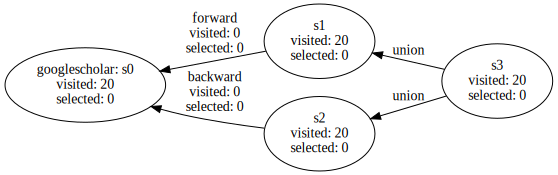

In [23]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs2016", filter_function=filter_function))
state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "googlescholar: s0"
    
print("\n \033[1mProvenance Graph - Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin) \033[0m")

FinalSelection(state)

In [24]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df


d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scholar=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)\033[0m")

df1_style


 Report Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)


,Scholar=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,googlescholar: s0,0,0,0,-,0,0,0,20,20,0,0
1,s2,nan,0,0,backward,0,0,0,0,20,0,0
2,s1,nan,0,0,forward,0,0,0,0,20,0,0
3,s3,nan,0,0,union,0,0,0,0,20,0,0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib_venn\_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


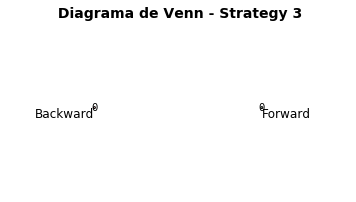

In [25]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 3',fontsize="14", fontweight="bold")
plt.show()

In [26]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward []
Forward []



## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 4 - Scopus + Snowballing (Guideline Wohlin) 


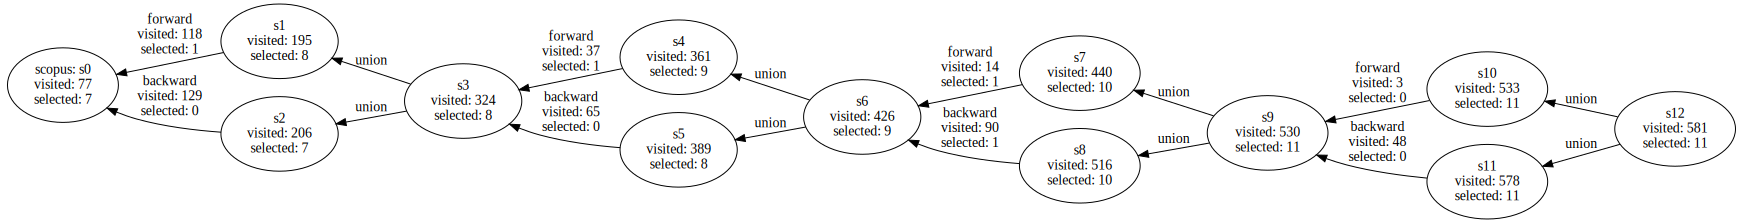

In [27]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))

state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"

print("\n \033[1mProvenance Graph - Strategy 4 - Scopus + Snowballing (Guideline Wohlin) \033[0m")

FinalSelection(state)

In [28]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 4 - Scopus + Snowballing (Guideline Wohlin)\033[0m")

df1_style


 Report Strategy 4 - Scopus + Snowballing (Guideline Wohlin)


,Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,scopus: s0,9.1,35,14.4,-,9.1,35,14.4,77,77,7,7
1,s2,0,0,0,backward,3.4,35,6.2,129,206,0,7
2,s1,0.8,5,1.4,forward,4.1,40,7.4,118,195,1,8
3,s3,nan,0,0,union,2.5,40,4.7,0,324,0,8
4,s5,0,0,0,backward,2.1,40,3.9,65,389,0,8
5,s4,2.7,5,3.5,forward,2.5,45,4.7,37,361,1,9
6,s6,nan,0,0,union,2.1,45,4,0,426,0,9
7,s8,1.1,5,1.8,backward,1.9,50,3.7,90,516,1,10
8,s7,7.1,5,5.9,forward,2.3,50,4.3,14,440,1,10
9,s9,nan,0,0,union,2.1,55,4,0,530,0,11


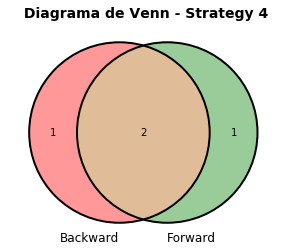

In [29]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 4',fontsize="14", fontweight="bold")
plt.show()

In [30]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['vlietland2015a', 'saddington2012a', 'waardenburg2013a']
Forward ['vlietland2015a', 'vlietland2016a', 'waardenburg2013a']


## Strategy 5 - Scopus + Snowballing (Short Paper)


 Provenance Graph - Strategy 5 - Scopus + Snowballing (Short Paper) 


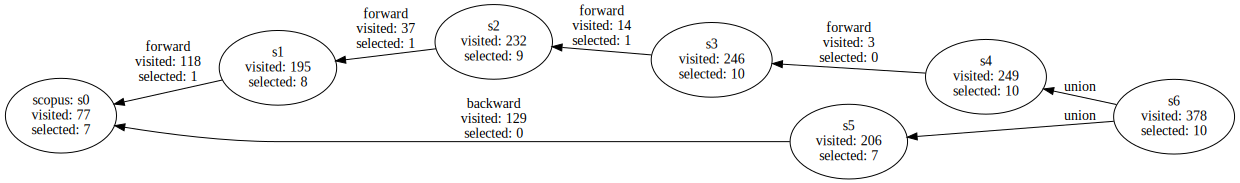

In [31]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.s2bbff2u()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
    
print("\n \033[1mProvenance Graph - Strategy 5 - Scopus + Snowballing (Short Paper) \033[0m")

FinalSelection(state)

In [32]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 5 - Scopus + Snowballing (Short Paper)\033[0m")

df1_style



 Report Strategy 5 - Scopus + Snowballing (Short Paper)


,Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,s1,0.8,5,1.4,forward,4.1,40,7.4,118,195,1,8
1,s2,2.7,5,3.5,forward,3.9,45,7.1,37,232,1,9
2,scopus: s0,9.1,35,14.4,-,9.1,35,14.4,77,77,7,7
3,s3,7.1,5,5.9,forward,4.1,50,7.5,14,246,1,10
4,s5,0,0,0,backward,3.4,35,6.2,129,206,0,7
5,s4,0,0,0,forward,4,50,7.4,3,249,0,10
6,s6,nan,0,0,union,2.6,50,5,0,378,0,10


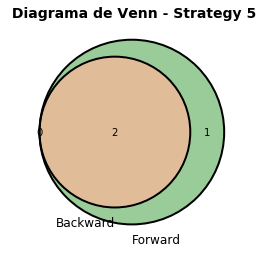

In [33]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 5',fontsize="14", fontweight="bold")
plt.show()

In [34]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['vlietland2015a', 'waardenburg2013a']
Forward ['vlietland2016a', 'vlietland2015a', 'waardenburg2013a']



  Bar Chart Strategy 5 


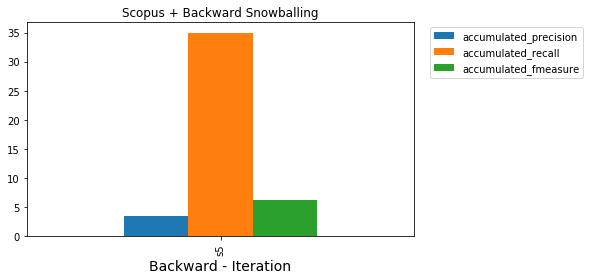

In [35]:
df1 = df.loc[df['operation'] == 'backward']

df1.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"])
ax = plt.gca()
ax.set_title("Scopus + Backward Snowballing")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.45, 1.0))
ax.set_xticklabels(df1["state"])
plt.xlabel("Backward - Iteration", fontsize="14")
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


  Bar Chart Strategy 5 


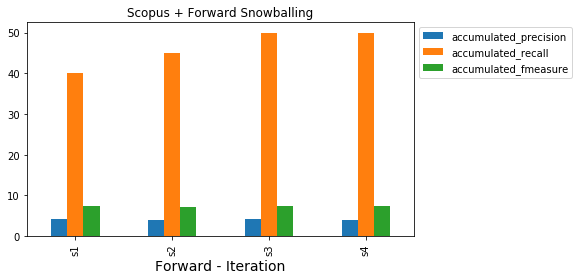

In [36]:
df2 = df.loc[df['operation'] == 'forward'].reset_index(drop=True)

df2.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"])
ax = plt.gca()
ax.set_title("Scopus + Forward Snowballing")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df2["state"])
plt.xlabel("Forward - Iteration", fontsize="14")
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


## Strategy 6 - Scopus + Snowballing (JF BF)


 Provenance Graph - Strategy 6 - Scopus + Snowballing (JF BF) 


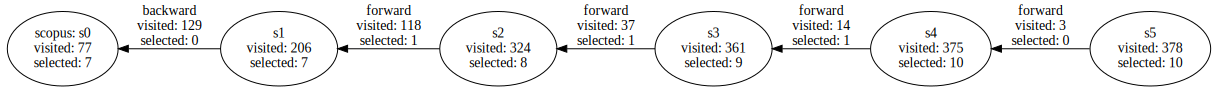

In [37]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.bbff()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
    
print("\n \033[1mProvenance Graph - Strategy 6 - Scopus + Snowballing (JF BF) \033[0m")

FinalSelection(state)

In [38]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

#print (strategy_row)
print("\n \033[1mReport Strategy 6 - Scopus + Snowballing (JF BF)\033[0m")

df1_style


 Report Strategy 6 - Scopus + Snowballing (JF BF)


,Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,scopus: s0,9.1,35,14.4,-,9.1,35,14.4,77,77,7,7
1,s1,0,0,0,backward,3.4,35,6.2,129,206,0,7
2,s2,0.8,5,1.4,forward,2.5,40,4.7,118,324,1,8
3,s3,2.7,5,3.5,forward,2.5,45,4.7,37,361,1,9
4,s4,7.1,5,5.9,forward,2.7,50,5.1,14,375,1,10
5,s5,0,0,0,forward,2.6,50,5,3,378,0,10


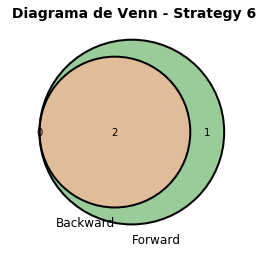

In [39]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 6',fontsize="14", fontweight="bold")
plt.show()

In [40]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['vlietland2015a', 'waardenburg2013a']
Forward ['vlietland2016a', 'vlietland2015a', 'waardenburg2013a']


## Strategy 7 - Scopus + Snowballing (JF FB)


 Provenance Graph - Strategy 7 - Scopus + Snowballing (JF FB) 


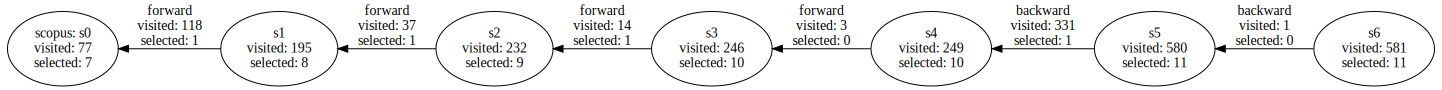

In [41]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.ffbb()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
    
print("\n \033[1mProvenance Graph - Strategy 7 - Scopus + Snowballing (JF FB) \033[0m")

FinalSelection(state)

In [42]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

print("\n \033[1mReport Strategy 7 - Scopus + Snowballing (JF FB)\033[0m")
#print (strategy_row)
df1_style



 Report Strategy 7 - Scopus + Snowballing (JF FB)


,Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
0,scopus: s0,9.1,35,14.4,-,9.1,35,14.4,77,77,7,7
1,s1,0.8,5,1.4,forward,4.1,40,7.4,118,195,1,8
2,s2,2.7,5,3.5,forward,3.9,45,7.1,37,232,1,9
3,s3,7.1,5,5.9,forward,4.1,50,7.5,14,246,1,10
4,s4,0,0,0,forward,4,50,7.4,3,249,0,10
5,s5,0.3,5,0.6,backward,1.9,55,3.7,331,580,1,11
6,s6,0,0,0,backward,1.9,55,3.7,1,581,0,11


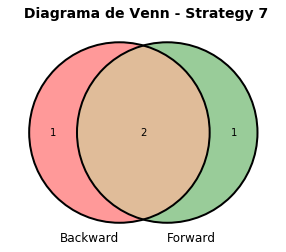

In [43]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 7',fontsize="14", fontweight="bold")
plt.show()

In [44]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['vlietland2015a', 'saddington2012a', 'waardenburg2013a']
Forward ['vlietland2015a', 'vlietland2016a', 'waardenburg2013a']


# Analyses

In [45]:
%matplotlib inline
import pandas as pd

In [46]:
df = pd.DataFrame (array)
#Esse array possui elementos do (11 ate o 23) 11o elem. até o último elem. pq estamos incluindo desde a Estrategia 1 somente esses elementos em strategy_row = [name] + last[11:].
#df.columns = ['name','related','visited','final_selected','excel','excel_selected','duplicated','accumulated_precision', 'accumulated_recall','accumulated_fmeasure','final_accumulated_precision','final_accumulated_recall','final_accumulated_fmeasure']
#df.index = df['Estratégia']
#df

df1 = df[[0, 7, 8, 9, 2, 1, 3]]  #seleção de somente alguns elementos do df do array, com posições diferentes 
df1.columns = ['Estratégia','Precision %', 'Recall %', 'F-Measure %','Visited', 'Related', 'Final Selected']

d_decimals = 3    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df1[coluna] = df1[coluna].map('{:,.2f}'.format)

    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Estratégia,Precision %,Recall %,F-Measure %,Visited,Related,Final Selected
0,E1,1.8,85,3.6,935,17,6
1,E2,1.3,100,2.5,1590,20,7
2,E3,0,0,0,20,0,0
3,E4,1.9,55,3.7,581,11,3
4,E5,2.6,50,5,378,10,2
5,E6,2.6,50,5,378,10,2
6,E7,1.9,55,3.7,581,11,3



  Bar Chart Strategies 


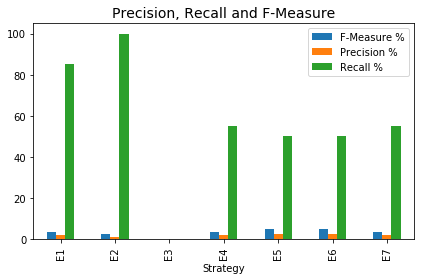

In [47]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar()
ax.set_title("Precision, Recall and F-Measure", fontsize ="14")
ax.set_xticklabels(df[0])
plt.xlabel("Strategy")
plt.tight_layout()

print ('\n \033[1m Bar Chart Strategies \033[0m')

In [48]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [49]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title